In [1]:
import torch
from torch import nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import CIFAR10 # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# obtain cfar10 data and process

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
data_loader_target = torch.utils.data.DataLoader(trainset, batch_size=150,
                                          shuffle=True, num_workers=0)
data_loader_gan = torch.utils.data.DataLoader(trainset, batch_size=150,
                                         shuffle=True, num_workers=0)
testset = CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
data_loader_test = torch.utils.data.DataLoader(trainset, batch_size=75,
                                         shuffle=True, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_of_classes = len(classes)

In [3]:
%%time 

# target model, resnet model from 
# https://github.com/kuangliu/pytorch-cifar
from net_conv_cifar import target_net, BasicBlock

if torch.cuda.is_available():  
    dev = 'cuda:0'
else:  
    dev = 'cpu'

print('device: ', dev)
print('-----------------------------')

net = target_net(BasicBlock, [2, 2, 2, 2]).to(dev)
criterion_tar = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

PATH = './target_models/basic_net_convolutional_CIFAR_device-'+dev+'.pth'
# train and and save the model
#net.train(data_loader_target, criterion_tar, optimizer, dev, 50)
#torch.save(net.state_dict(), PATH)
# load the model
net = target_net(BasicBlock, [2, 2, 2, 2]).to(dev)
net.load_state_dict(torch.load(PATH),dev)

print('model accuracy: ', net.accuracy(data_loader_test,dev))

device:  cuda:0
-----------------------------
model accuracy:  100.0
CPU times: user 20.2 s, sys: 1.5 s, total: 21.7 s
Wall time: 21.7 s


In [4]:
from advGAN_conv_cifar import advGAN
advgan = advGAN(net,disc_coeff=49.,hinge_coeff=77.,adv_coeff=10.,c=0.2,gen_path_extra='basic_advgan_conv_CIFAR10',device=dev)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  1
Step 500: Generator loss: 188.90673092651377, discriminator loss: 33.85214978790282
% wrong: 0.38 | target model % correct: 1.0


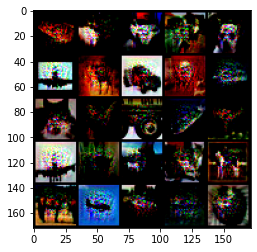

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


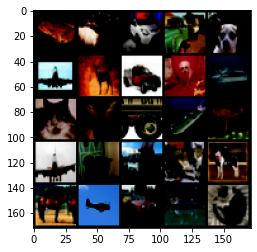

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  2
Step 1000: Generator loss: 168.58639276123023, discriminator loss: 30.4649718170166
% wrong: 0.29333333333333333 | target model % correct: 1.0


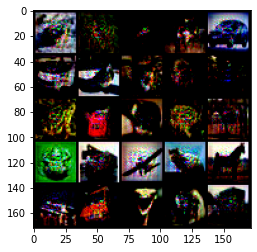

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


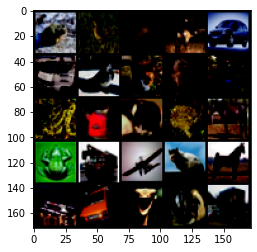

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  4
Step 1500: Generator loss: 159.2645378723145, discriminator loss: 25.69838189697265
% wrong: 0.30666666666666664 | target model % correct: 1.0


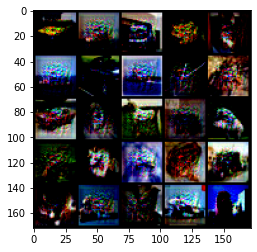

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


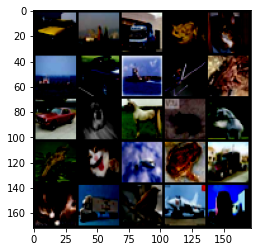

KeyboardInterrupt: 

In [5]:
%%time
# train the gen/disc
gen,disc = advgan.train(data_loader_gan)

In [ ]:
# load the generator 
gen = advgan.load_gen()

In [ ]:
from sklearn.metrics import accuracy_score

def one_batch(data,num=1):
    for i,(img,lbl) in enumerate(data):
        if i == num:
            return img,lbl
            break

images,labels = one_batch(data_loader_test,num=1)
perts = gen(images.to(dev))
adv_images = (images.to(dev) + perts).to(dev)
net_out = net(images.to(dev)).to(dev)
adv_pred = net(adv_images).to(dev)

print('% wrong: ',1.-accuracy_score(labels.cpu(),torch.argmax(adv_pred,dim=1).cpu()))
print('-----------------------------------------')
for img,lbl,adimg,out,adpred,p in zip(images,labels,adv_images,net_out,adv_pred,perts):
    print('target model output: ', int(torch.argmax(out).detach()))
    print('target model output on adv example: ', int(torch.argmax(adpred).detach()))
    print('frobenius norm of pertubation: ',float(torch.norm(p,'fro').detach()))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('actual label: '+str(int(lbl.detach())))
    ax1.imshow(img.reshape(28,28).detach().numpy(),cmap='gray')
    ax2.imshow(adimg.reshape(28,28).cpu().detach().numpy(),cmap='gray')
    plt.show()


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

img = torch.rand((5,1,28,28))

In [ ]:
class Generator(nn.Module):
    def __init__(self, image_nc=1,ngf = 18):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(1,1,9)
        self.pool1 = nn.MaxPool2d(2,1) 
        self.conv2 = nn.Conv2d(1,1,7)
        self.pool2 = nn.MaxPool2d(2,1)

        self.fc1 = nn.Linear(144,100)
        self.fc2 = nn.Linear(100,64) 

        self.c2 = nn.ConvTranspose2d(1,1,7)
        self.norm2 = nn.BatchNorm2d(1)
        self.c1 = nn.ConvTranspose2d(1,1,11)
        self.norm1 = nn.BatchNorm2d(1)
        self.c0 = nn.ConvTranspose2d(1,1,5)

    def forward(self,x):
        leaky_relu = nn.LeakyReLU(.2)
        relu = nn.ReLU()
        tanh = nn.Tanh()
        # convolution part
        x = leaky_relu(self.pool1(self.conv1(x)))
        x = leaky_relu(self.pool2(self.conv2(x)))
        x = x.reshape(x.shape[0],x.shape[-1]**2)
        # linear part
        x = leaky_relu(self.fc1(x))
        x = leaky_relu(self.fc2(x))
        x = x.reshape(x.shape[0],1,8,8)
        # transpose conv part
        x = relu(self.norm2(self.c2(x)))
        x = relu(self.norm1(self.c1(x)))
        x = tanh(self.c0(x))
        return x

class Discriminator(nn.Module):
    def __init__(self, image_nc=1):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1,1,7)
        self.pool1 = nn.MaxPool2d(1,1) 
        self.conv2 = nn.Conv2d(1,1,7)
        self.pool2 = nn.MaxPool2d(1,2)  
        self.fc1 = nn.Linear(8*8,32) 
        self.fc2 = nn.Linear(32,16) 
        self.fc3 = nn.Linear(16,1) 

    def forward(self, x):
        leaky_relu = nn.LeakyReLU(.2)
        x = leaky_relu(self.pool1(self.conv1(x)))
        x = leaky_relu(self.pool2(self.conv2(x)))
        x = x.reshape(x.shape[0],x.shape[-1]**2)
        x = leaky_relu(self.fc1(x))
        x = leaky_relu(self.fc2(x))
        x = leaky_relu(self.fc3(x))
        return x
    
gen = Generator()
disc = Discriminator()

In [ ]:
x = img

disc(x).shape

# conv1 = nn.Conv2d(1,1,7)
# pool1 = nn.MaxPool2d(1,1) 
# conv2 = nn.Conv2d(1,1,7)
# pool2 = nn.MaxPool2d(1,2) 
# x = pool2(conv2(pool1(conv1(x))))
# x = x.reshape(x.shape[0],x.shape[-1]**2)

# fc1 = nn.Linear(8*8,32) 
# fc2 = nn.Linear(32,16) 
# fc3 = nn.Linear(16,1) 

# x = fc3(fc2(fc1(x)))

# x.shape